# CodonFM on mRFP expression


## Learning Goals
- Predict mRFP expression from mRNA sequences
- Learn how to use a pretrained Encodon and Random Forest Regressor model
- Use EncodonInference wrapper for embedding extraction

## Prerequisites

*   Python version 3.12
*   T4 GPU


## Introduction
CodonFM Encodon is a suite of transformer-based models that predict masked codons in mRNA sequences to enable variant effect interpretation and codon optimization. The models process sequences up to 2,046 codons (6,138 nucleotides) and output codon probability distributions for each position.  

We will use a pretrained Encodon and Random Forest Regressor model to predict mRFP expression using the Sanofi mRFP expression dataset. We will use the EncodonInference wrapper for embedding extraction.

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')

## Setup

### Google Colab

Before starting, connect to the T4 GPU runtime hosted for free by Google Colab using the dropdown menu in the upper right hand corner of this notebook. **Please note that Google Colab continuously updates CUDA/pytorch versions, and the following installation was tested to work on T4 GPUs in Oct 2025 and later on A100 GPUs in Dec 2025 using Python 3.12.**

### Local Environment
The below installation procedure can work on local machines, but for guaranteed reproducibility the following Dockerfile is suggested for building and running inside a container: https://github.com/NVIDIA-Digital-Bio/CodonFM/blob/main/Dockerfile

### Clone repository and install dependencies




In [3]:
!git clone --branch colab-environment https://github.com/NVIDIA-Digital-Bio/CodonFM

fatal: destination path 'CodonFM' already exists and is not an empty directory.


In [4]:
%cd CodonFM

/content/CodonFM


In [5]:
!uv pip install -r requirements.txt


Using Python 3.12.12 environment at: /usr
Resolved 167 packages in 1.05s
Prepared 41 packages in 3.74s
Uninstalled 1 package in 50ms
Installed 41 packages in 53ms
 + anndata==0.12.6
 + array-api-compat==1.12.0
 + autopage==0.5.2
 + biopython==1.85
 + cfgv==3.5.0
 + cliff==4.13.0
 + cmaes==0.12.0
 + cmd2==2.7.0
 + colorlog==6.10.1
 + distlib==0.4.0
 + donfig==0.8.1.post1
 + fiddle==0.3.0
 + hydra-colorlog==1.2.0
 + hydra-core==1.3.2
 + hydra-optuna-sweeper==1.2.0
 + identify==2.6.15
 + ipython-autotime==0.3.2
 + jedi==0.19.2
 + legacy-api-wrap==1.5
 + libcst==1.8.6
 + lightning==2.5.2
 + lightning-utilities==0.15.2
 + lru-dict==1.3.0
 + ninja==1.11.1.1
 + nodeenv==1.9.1
 + numcodecs==0.16.5
 + optuna==2.10.1
 + pre-commit==4.0.1
 + pyfaidx==0.8.1.4
 + pytorch-lightning==2.6.0
 + rich-argparse==1.7.2
 + rootutils==1.0.7
 + scanpy==1.11.3
 - scipy==1.16.3
 + scipy==1.15.3
 + session-info2==0.2.3
 + sh==2.2.2
 + stevedore==5.6.0
 + torchmetrics==1.8.2
 + virtualenv==20.35.4
 + xformers==0.

We install `transformers` and `tokenizers` to the appropriate versions using a separate command in order to avoid unexpected behavior or modifying other dependencies.

In [6]:
!uv pip install --system --no-deps transformers==4.54.1 tokenizers==0.21

Using Python 3.12.12 environment at: /usr
Resolved 2 packages in 3ms
Prepared 2 packages in 400ms
Uninstalled 2 packages in 306ms
Installed 2 packages in 46ms
 - tokenizers==0.22.1
 + tokenizers==0.21.0
 - transformers==4.57.3
 + transformers==4.54.1


In [7]:
!uv pip check


Using Python 3.12.12 environment at: /usr
Checked 742 packages in 90ms
All installed packages are compatible


### Import libraries and Encodon modules


Next, import the necessary libraries and the Encodon module. We also check to ensure PyTorch and CUDA are working.

In [8]:
import os
import sys
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, GridSearchCV

# Visualization
import matplotlib.pyplot as plt

# Add project paths
sys.path.append('..')

# Import Encodon modules
from src.inference.encodon import EncodonInference
from src.inference.task_types import TaskTypes
from src.data.metadata import MetadataFields

# Import additional modules for dataset handling
from src.data.codon_bert_dataset import CodonBertDataset
from src.data.preprocess.codon_sequence import process_item
from torch.utils.data import DataLoader

# Fix random seed
torch.manual_seed(42)
np.random.seed(42)

print("✅ Libraries imported successfully!")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if "+cu126" not in torch.__version__:
    print(f"⚠️  Warning: Torch build ({torch.__version__}) is not cu126, indicating the Colab environment has changed"
          " since this was last tested in October 2025. Functionality might be affected.")

✅ Libraries imported successfully!
PyTorch: 2.9.0+cu126
CUDA available: True


###Download mRFP dataset

In [9]:
# Download mRFP Expression dataset if it doesn't exist

# NOTE: This assumes the notebook was launched from the codon-fm source directory.
# NOTE: otherwise change the path for the `subprocess` launch to correspond to the data_scripts path correctly
import subprocess

data_path = "mRFP_Expression.csv"
root_path = "."
if not os.path.exists(data_path):
    print("📥 Downloading mRFP Expression dataset...")
    try:
        subprocess.run([
            "python", "data_scripts/download_preprocess_codonbert_bench.py",
            "--dataset", "mRFP_Expression.csv",
            "--output-dir", root_path
        ], check=True)
        print("✅ Dataset downloaded and preprocessed successfully!")
    except subprocess.CalledProcessError as e:
        print(f"❌ Error downloading dataset: {e}")
        print("Please ensure the data_scripts are available and run manually if needed.")
else:
    print("✅ Dataset already exists!")


📥 Downloading mRFP Expression dataset...
✅ Dataset downloaded and preprocessed successfully!


### Load pretrained Encodon model



In [10]:
!git clone https://huggingface.co/nvidia/NV-CodonFM-Encodon-1B-v1

Cloning into 'NV-CodonFM-Encodon-1B-v1'...
remote: Enumerating objects: 6, done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 6 (from 1)
Unpacking objects: 100% (6/6), 5.17 KiB | 5.17 MiB/s, done.


In [11]:
# Define checkpoint paths
checkpoint_paths = [
    "NV-CodonFM-Encodon-1B-v1/NV-CodonFM-Encodon-1B-v1.safetensors",
]

checkpoint_path = checkpoint_paths[0]
model_loaded = False
if os.path.exists(checkpoint_path):
    try:
        device = "cuda" if torch.cuda.is_available() else "cpu"

        # Create EncodonInference wrapper
        encodon_model = EncodonInference(
            model_path=checkpoint_path,
            task_type=TaskTypes.EMBEDDING_PREDICTION,
        )

        # Configure model
        encodon_model.configure_model()
        encodon_model.to(device)
        encodon_model.eval()

        print(f"✅ Model loaded from: {checkpoint_path}")
        print(f"Device: {device}")
        print(f"Parameters: {sum(p.numel() for p in encodon_model.model.parameters()):,}")

        model_loaded = True
    except Exception as e:
        print(f"Failed to load {checkpoint_path}: {e}")

if not model_loaded:
    print("❌ Could not load any model. Please check checkpoint paths.")

✅ Model loaded from: NV-CodonFM-Encodon-1B-v1/NV-CodonFM-Encodon-1B-v1.safetensors
Device: cuda
Parameters: 911,304,773


###Load dataset

In [12]:
# Load mRFP Expression dataset
data_loaded = False
if os.path.exists(data_path):
    try:
        data = pd.read_csv(data_path)
        print(f"✅ Loaded {len(data)} samples from: {data_path}")
        print(f"Columns: {list(data.columns)}")

        if 'split' in data.columns:
            print(f"Data splits: {data['split'].value_counts().to_dict()}")

        print(f"Target range: [{data['value'].min():.3f}, {data['value'].max():.3f}]")
        data_loaded = True
    except Exception as e:
        print(f"Failed to load {data_path}: {e}")

if not data_loaded:
    print("❌ Could not load mRFP data")

✅ Loaded 1459 samples from: mRFP_Expression.csv
Columns: ['id', 'ref_seq', 'value', 'dataset', 'split']
Data splits: {'train': 1021, 'val': 219, 'test': 219}
Target range: [7.361, 11.379]


###Preprocess data

This step takes an estimated 30 minutes using a T4 GPU.

In [13]:
batch_size = 16
if data_loaded and model_loaded:
    print("=== DATA PREPROCESSING ===")
    # Create dataset
    dataset = CodonBertDataset(
        data_path=data_path,
        tokenizer=encodon_model.tokenizer,
        process_item=lambda seq, tokenizer: process_item(
            seq,
            context_length=encodon_model.model.hparams.max_position_embeddings,
            tokenizer=tokenizer
        )
    )

    print(f"Processing {len(dataset)} sequences")
    print(f"Target range: [{dataset.data['value'].min():.3f}, {dataset.data['value'].max():.3f}]")

    # Create data loader for batch processing
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Extract embeddings using the dataset
    print("\nExtracting embeddings...")
    all_embeddings = []
    all_labels = []

    for batch in tqdm(dataloader):
        batch_input = {
            MetadataFields.INPUT_IDS: batch[MetadataFields.INPUT_IDS].to(encodon_model.device),
            MetadataFields.ATTENTION_MASK: batch[MetadataFields.ATTENTION_MASK].to(encodon_model.device),
        }

        # Extract embeddings
        output = encodon_model.extract_embeddings(batch_input)
        all_embeddings.append(output.embeddings)
        all_labels.append(batch[MetadataFields.LABELS].numpy())

    # Combine all embeddings and labels
    embeddings = np.vstack(all_embeddings)
    targets = np.concatenate(all_labels)

    print(f"\n✅ Extracted embeddings: {embeddings.shape}")

else:
    print("❌ Skipping preprocessing")

=== DATA PREPROCESSING ===
Processing 1459 sequences
Target range: [7.361, 11.379]

Extracting embeddings...


100%|██████████| 92/92 [05:51<00:00,  3.82s/it]


✅ Extracted embeddings: (1459, 2048)


###Random forest model

We use zero shot sequence embeddings of the model and train the random forest model to predict the mRFP expression. Then we calculate the metrics for the training, validation, and test sets so we can plot them in the following step.

This step takes around 50 minutes using a T4 GPU.

In [14]:
if 'embeddings' in locals():
    print("=== TRAINING RANDOM FOREST ===")

    # Split data based on the dataset splits
    train_mask = dataset.data['split'] == 'train'
    val_mask = dataset.data['split'] == 'val'
    test_mask = dataset.data['split'] == 'test'

    X_train = embeddings[train_mask]
    X_val = embeddings[val_mask]
    X_test = embeddings[test_mask]
    y_train = targets[train_mask]
    y_val = targets[val_mask]
    y_test = targets[test_mask]

    print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

    # Combine train and validation for GridSearchCV
    X_train_val = np.vstack([X_train, X_val])
    y_train_val = np.concatenate([y_train, y_val])

    # Create validation indices for GridSearchCV
    # Train indices: 0 to len(X_train)-1
    # Val indices: len(X_train) to len(X_train_val)-1
    train_indices = list(range(len(X_train)))
    val_indices = list(range(len(X_train), len(X_train_val)))
    cv_splits = [(train_indices, val_indices)]

    # Define hyperparameter grid
    param_grid = {
        'n_estimators': [1000],
        'max_depth': [10],
        'min_samples_split': [25],
        'min_samples_leaf': [2],
    }

    # Create base model
    rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

    # Grid search with validation split
    print("Performing hyperparameter tuning...")
    grid_search = GridSearchCV(
        estimator=rf_base,
        param_grid=param_grid,
        cv=cv_splits,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )

    # Fit grid search
    grid_search.fit(X_train_val, y_train_val)

    # Get best model
    rf = grid_search.best_estimator_

    print(f"\n=== BEST PARAMETERS ===")
    for param, value in grid_search.best_params_.items():
        print(f"{param}: {value}")
    print(f"Best validation R²: {grid_search.best_score_:.4f}")

    # Train final model on train set only
    rf.fit(X_train, y_train)

    # Predictions on all splits
    y_pred_train = rf.predict(X_train)
    y_pred_val = rf.predict(X_val)
    y_pred_test = rf.predict(X_test)

    # Calculate metrics for all splits
    train_r2 = r2_score(y_train, y_pred_train)
    val_r2 = r2_score(y_val, y_pred_val)
    test_r2 = r2_score(y_test, y_pred_test)

    train_spearmanr, _ = spearmanr(y_train, y_pred_train)
    val_spearmanr, _ = spearmanr(y_val, y_pred_val)
    test_spearmanr, _ = spearmanr(y_test, y_pred_test)

    print(f"\n=== FINAL RESULTS ===")
    print(f"Train R²: {train_r2:.4f} | Spearman r: {train_spearmanr:.4f}")
    print(f"Val R²:   {val_r2:.4f} | Spearman r: {val_spearmanr:.4f}")
    print(f"Test R²:  {test_r2:.4f} | Spearman r: {test_spearmanr:.4f}")

else:
    print("❌ Cannot train - missing data")


=== TRAINING RANDOM FOREST ===
Train: 1021, Val: 219, Test: 219
Performing hyperparameter tuning...
Fitting 1 folds for each of 1 candidates, totalling 1 fits

=== BEST PARAMETERS ===
max_depth: 10
min_samples_leaf: 2
min_samples_split: 25
n_estimators: 1000
Best validation R²: 0.4652

=== FINAL RESULTS ===
Train R²: 0.7808 | Spearman r: 0.8891
Val R²:   0.4652 | Spearman r: 0.6386
Test R²:  0.4397 | Spearman r: 0.7309


### Plot results

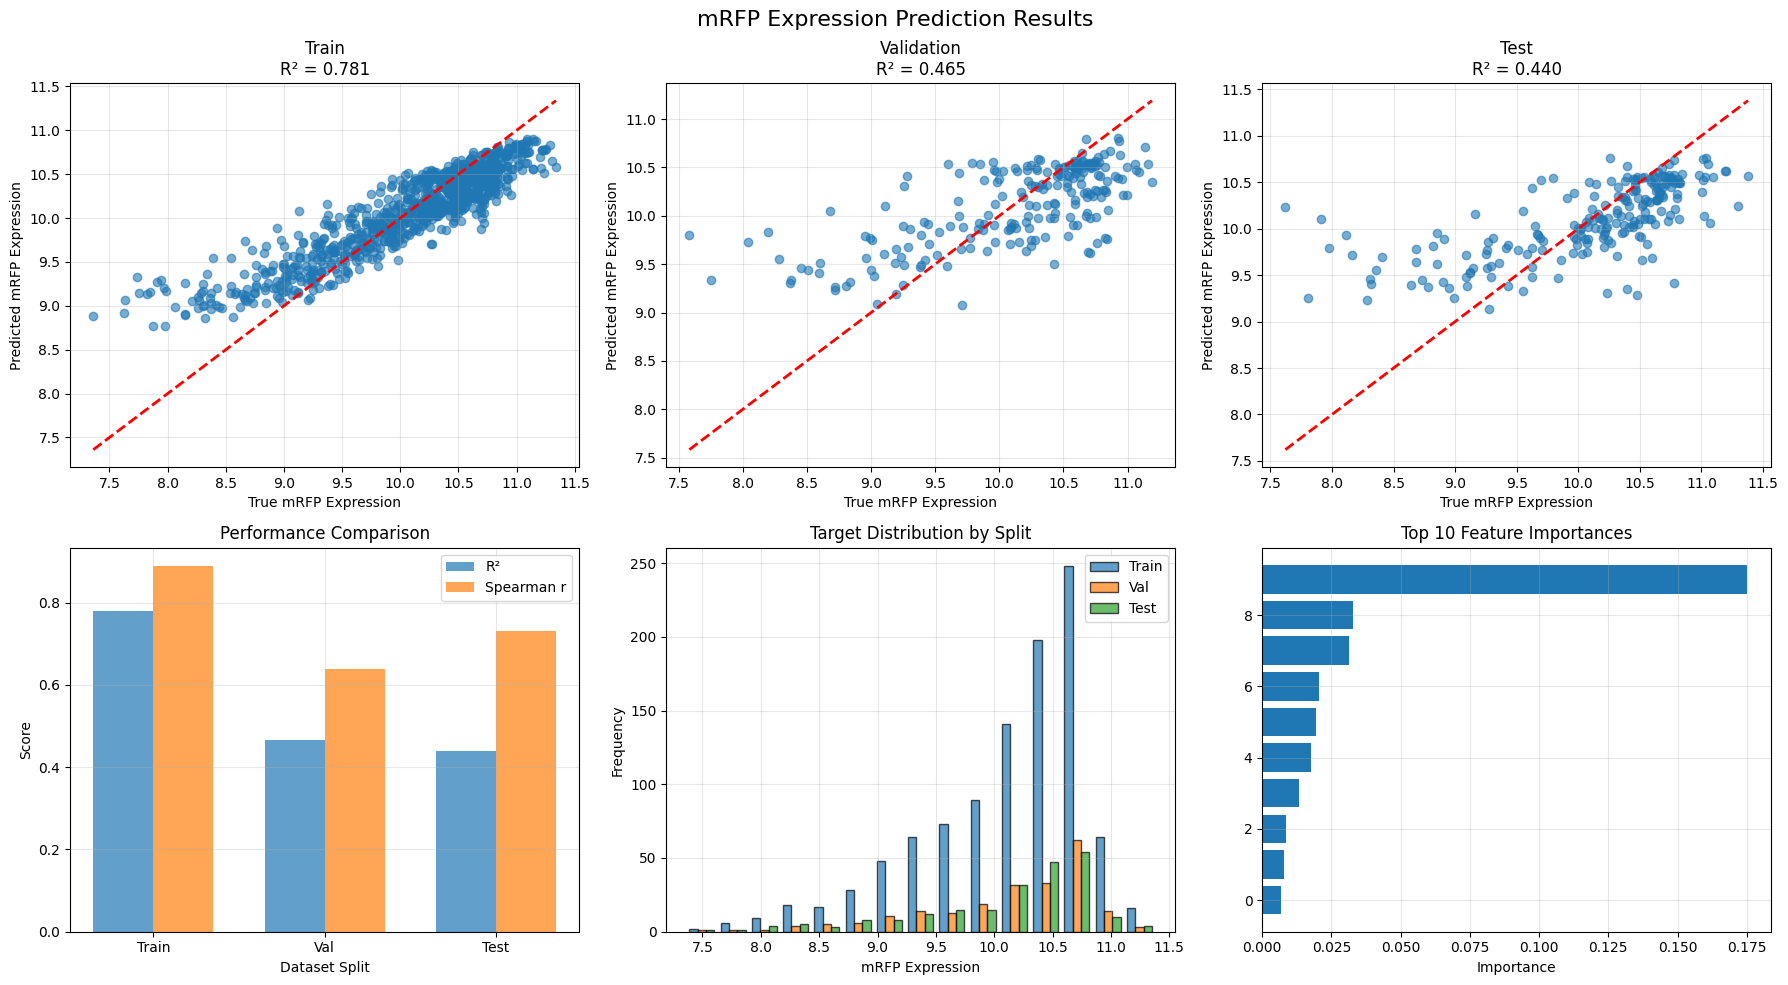

In [15]:
if 'y_test' in locals():
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('mRFP Expression Prediction Results', fontsize=16)

    # Predicted vs True for all splits
    splits = [('Train', y_train, y_pred_train, train_r2),
              ('Validation', y_val, y_pred_val, val_r2),
              ('Test', y_test, y_pred_test, test_r2)]

    for i, (split_name, y_true, y_pred, r2) in enumerate(splits):
        axes[0, i].scatter(y_true, y_pred, alpha=0.6)
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        axes[0, i].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
        axes[0, i].set_xlabel('True mRFP Expression')
        axes[0, i].set_ylabel('Predicted mRFP Expression')
        axes[0, i].set_title(f'{split_name}\nR² = {r2:.3f}')
        axes[0, i].grid(True, alpha=0.3)

    # Performance comparison
    r2_scores = [train_r2, val_r2, test_r2]
    spearmanr_scores = [train_spearmanr, val_spearmanr, test_spearmanr]

    x_pos = np.arange(len(splits))
    width = 0.35

    axes[1, 0].bar(x_pos - width/2, r2_scores, width, label='R²', alpha=0.7)
    axes[1, 0].bar(x_pos + width/2, spearmanr_scores, width, label='Spearman r', alpha=0.7)
    axes[1, 0].set_xlabel('Dataset Split')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].set_title('Performance Comparison')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(['Train', 'Val', 'Test'])
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Target distribution across splits
    axes[1, 1].hist([y_train, y_val, y_test], bins=15, alpha=0.7,
                   label=['Train', 'Val', 'Test'], edgecolor='black')
    axes[1, 1].set_xlabel('mRFP Expression')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Target Distribution by Split')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Feature importance
    top_features = np.argsort(rf.feature_importances_)[-10:]
    axes[1, 2].barh(range(10), rf.feature_importances_[top_features])
    axes[1, 2].set_xlabel('Importance')
    axes[1, 2].set_title('Top 10 Feature Importances')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

else:
    print("❌ No results to plot")

### Results
* `splits`: predicted vs true for all dataset splits
* mRFP expression plots for training, validation, and test splits
* `<SET_NAME>_r2` and `<SET_NAME>_spearmanr`: R^2 and Spearman r correlation for all dataset splits
* `top_features`: feature importances

## Troubleshooting & Optimization Tips

### Common Issues and Solutions:

#### 1. Model Loading Issues
- **Problem**: Checkpoint not found
- **Solution**: Update checkpoint paths in Step 4
- **Check**: Verify checkpoint files exist and are accessible

#### 2. Data Loading Issues
- **Problem**: Dataset not found
- **Solution**: Update data paths in Step 5
- **Check**: Ensure CSV files have required columns (id, ref_seq, value)

#### 3. Memory Issues
- **Problem**: CUDA out of memory
- **Solution**: Reduce batch_size in data preprocessing section
- **Alternative**: Use CPU by setting device='cpu'

#### 4. Performance Issues
- **Problem**: Low R² scores
- **Solutions**:
  - Try larger models (600M or 1B parameters)
  - Implement fine-tuning instead of just embeddings
  - Tune Random Forest hyperparameters
  - Check data quality and preprocessing


### Optimization Strategies:

#### 1. Model Architecture
- **80M model**: Fast, good for initial experiments
- **600M model**: Better performance, moderate cost
- **1B model**: Best performance, highest computational cost

#### 2. Hyperparameter Tuning
```python
# Try these Random Forest parameters:
rf_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
```

### Contact and Acknowledgments

This notebook is a clone from this repo - https://github.com/NVIDIA-Digital-Bio/CodonFM/blob/main/notebooks/5-EnCodon-Downstream-Task-mRFP-expression.ipynb

For issues with this quickstart please contact Timur Rvachov at trvachov@nvidia.com.

We thank the NVIDIA Corporation team for developing this suite of models.